The logic of `gradient boosting` is very simple (if explained intuitively, without using mathematical notation). I expect that whoever is reading this would have done `simple linear regression modeling`. 

One of the very basic assumption of linear regression is that it's sum of residuals is 0. Although, tree based models are not based on any of such assumptions, but if we think logic (not statistics) behind these assumptions, we might argue that, if sum of residuals is not 0, then most probably there is some pattern in the residuals of our model which can be leveraged to make our model better. 

So, the intuition behind `gradient boosting` algorithm is to leverage the pattern in residuals and strenghten a weak prediction model, until our residuals become randomly (maybe random normal too) distributed. Once we reach a stage that residuals do not have any pattern that can be modeled, we can stop modeling residuals (as it might lead to overfitting). 

In [1]:
# load the libraries 
%matplotlib inline

from fastai.imports import *
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn import metrics

In [2]:
# standard aggregation function 
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [3]:
class DecisionTree():
    # define the parameters of the tree
    def __init__(self, x, y, indexes = None, minleaf=2):
        if indexes is None: indexes=np.arange(len(y))
        self.x,self.y,self.indexes,self.minleaf = x,y,indexes,minleaf
        self.n,self.c = len(indexes), x.shape[1]
        self.valmean = np.mean(y[indexes])
        self.score = float('inf')
        self.findvarsplit()

    # find the splitting values for the left and right branch  
    def findvarsplit(self):
        for i in range(self.c): self.findbettersplit(i)
        if self.score == float('inf'): return
        x = self.splitcol
        left = np.nonzero(x<=self.split)[0]
        right = np.nonzero(x>self.split)[0]
        self.left = DecisionTree(self.x, self.y, self.indexes[left])
        self.right = DecisionTree(self.x, self.y, self.indexes[right])

    # find the optimum split values for the branches 
    def findbettersplit(self, var_idx):
        x,y = self.x.values[self.indexes,var_idx], self.y[self.indexes]
        sortindex = np.argsort(x)
        sorty,sortx = y[sortindex], x[sortindex]
        cnt_right,sum_right,sum_right2 = self.n, sorty.sum(), (sorty**2).sum()
        cnt_left,sum_left,sum_left2 = 0,0.,0.

        for i in range(0,self.n-self.minleaf-1):
            xi,yi = sortx[i],sorty[i]
            cnt_left += 1; cnt_right -= 1
            sum_left += yi; sum_right -= yi
            sum_left2 += yi**2; sum_right2 -= yi**2
            if i<self.minleaf or xi==sortx[i+1]:
                continue

            std_left = std_agg(cnt_left, sum_left, sum_left2)
            std_right = std_agg(cnt_right, sum_right, sum_right2)
            currentscore = std_left*cnt_left + std_right*cnt_right
            if currentscore<self.score: 
                self.var_idx,self.score,self.split = var_idx,currentscore,xi

    @property
    def splitname(self): return self.x.columns[self.var_idx]
    
    @property
    def splitcol(self): return self.x.values[self.indexes,self.var_idx]

    @property
    def isleaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; valmean:{self.valmean}'
        if not self.isleaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.splitname}'
        return s

    # predict the y values for the x input 
    def predict(self, x):
        return np.array([self.predictrow(xi) for xi in x])

    
    def predictrow(self, xi):
        if self.isleaf: return self.valmean
        t = self.left if xi[self.var_idx]<=self.split else self.right
        return t.predictrow(xi)

In [4]:
# create a sample x value
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [5]:
# define y values in random uniform distribution

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]


In [6]:
x.shape, y.shape

((50, 1), (50, 1))

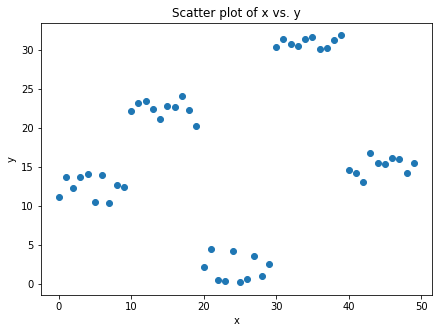

In [7]:
# plot the scatter plot of the x and y values 
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

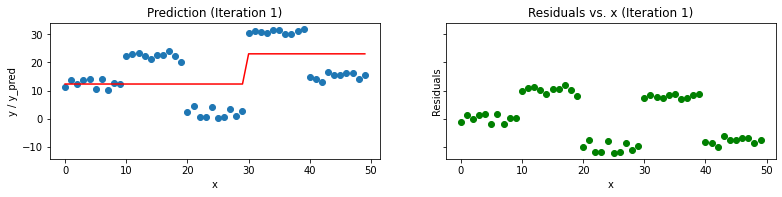

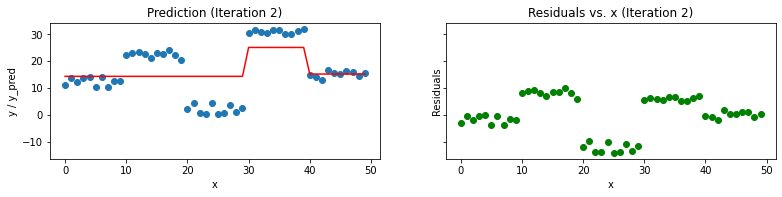

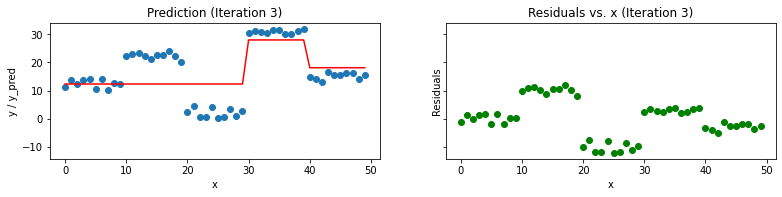

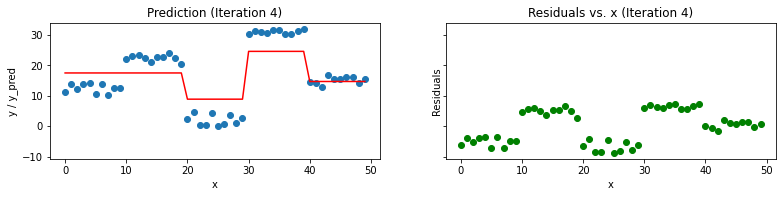

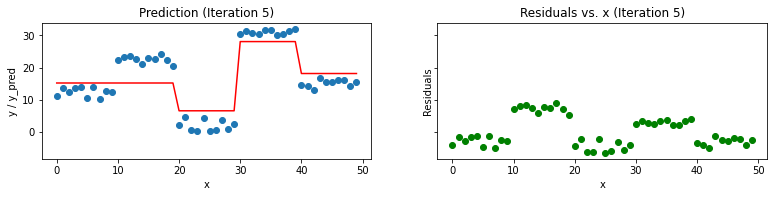

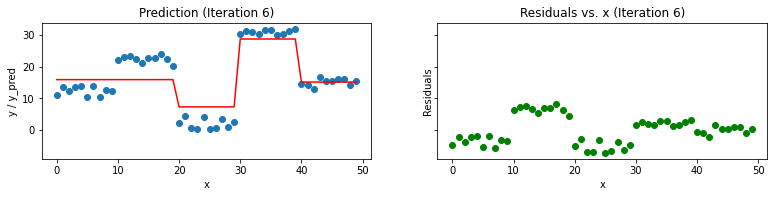

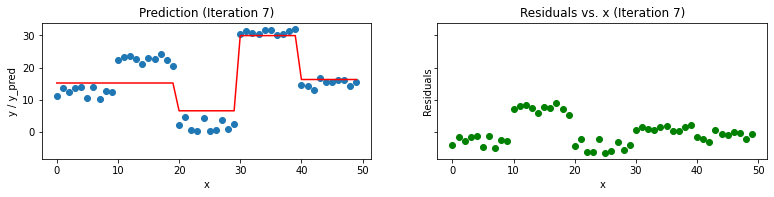

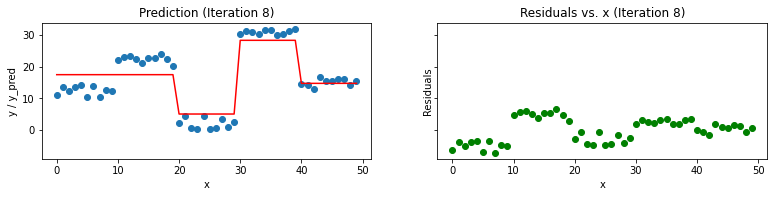

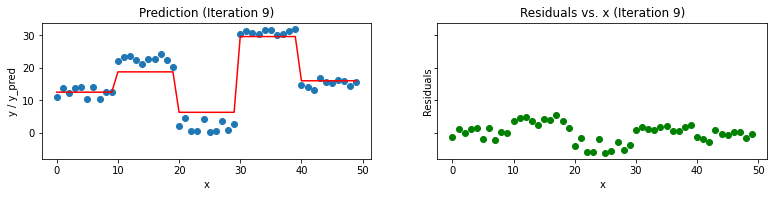

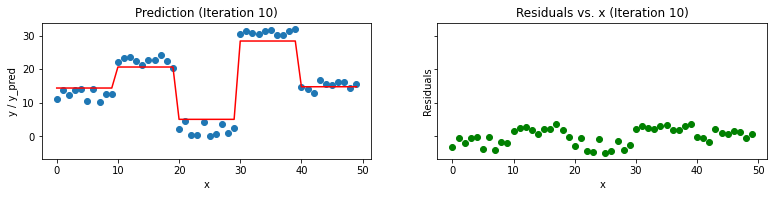

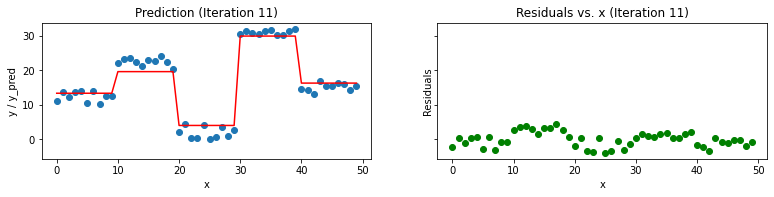

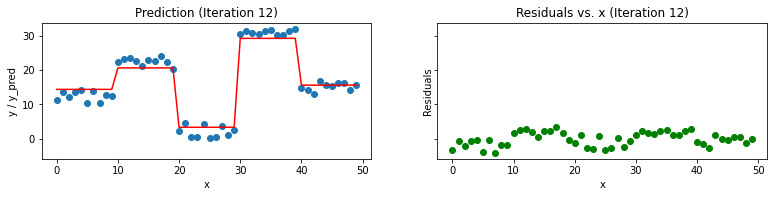

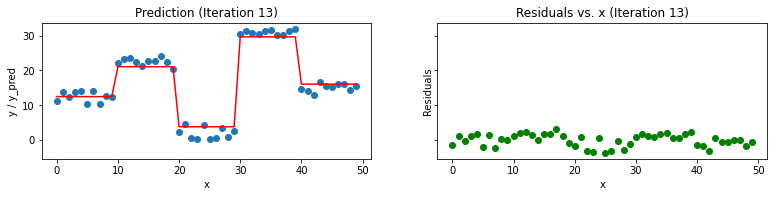

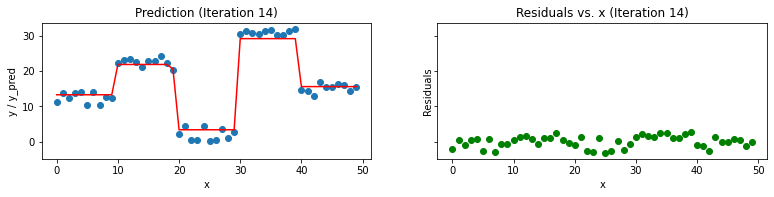

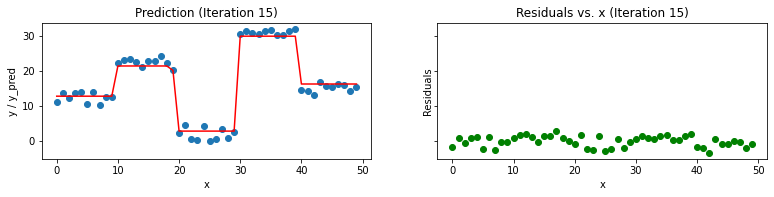

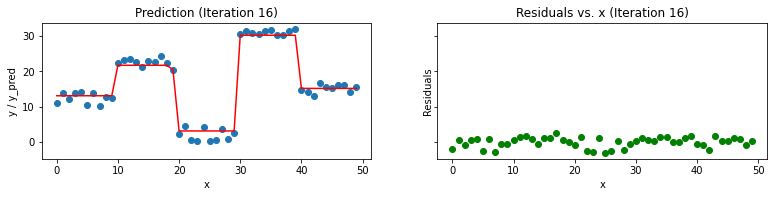

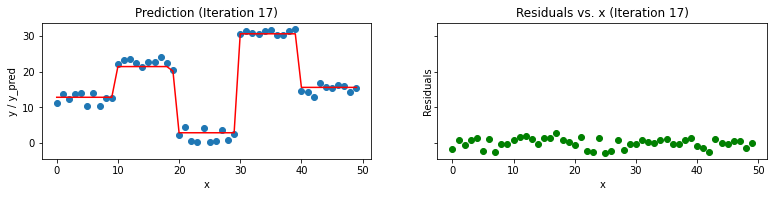

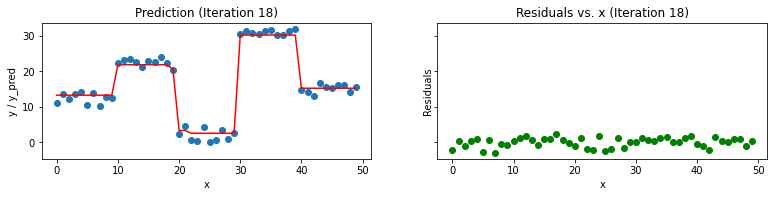

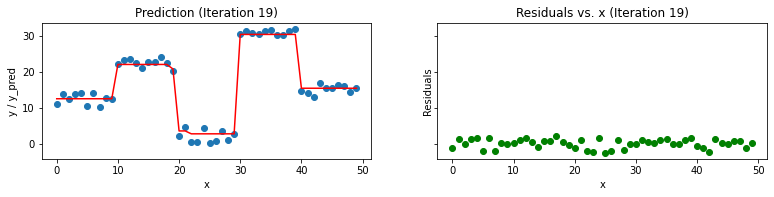

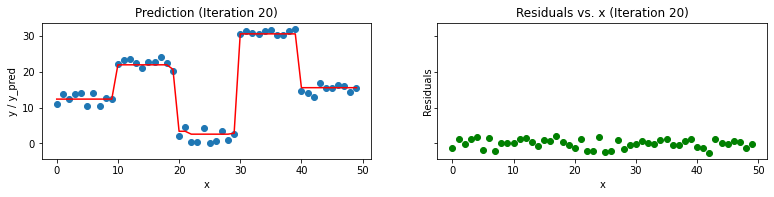

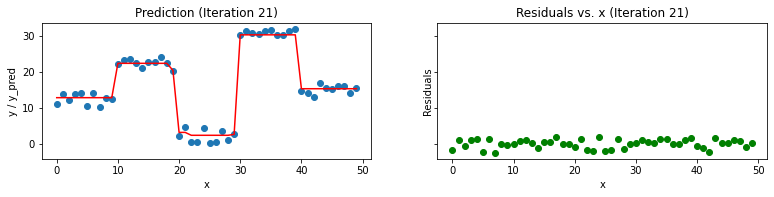

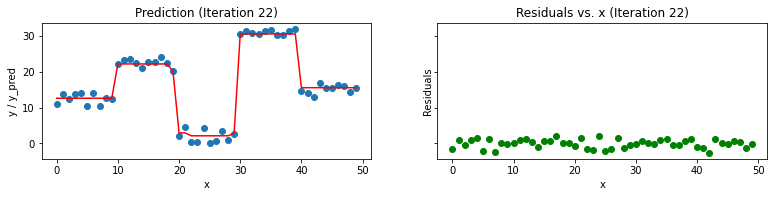

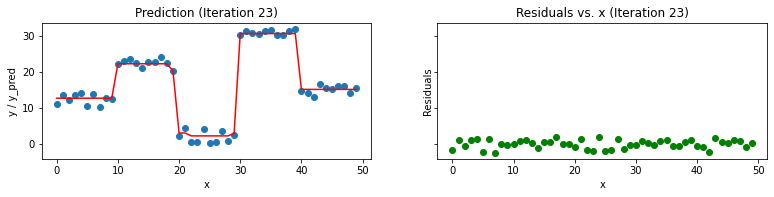

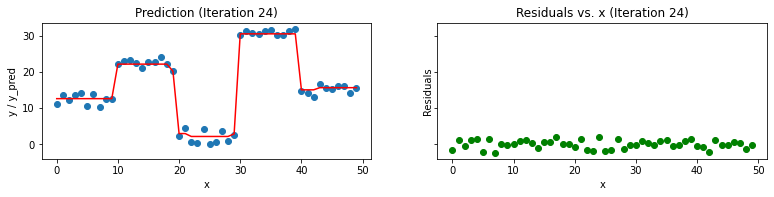

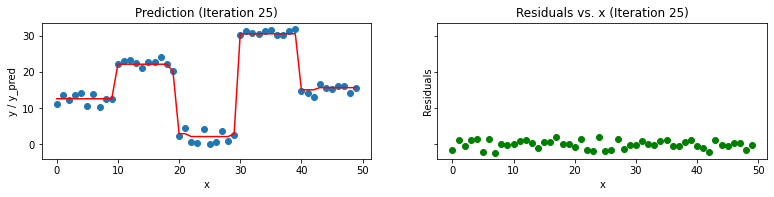

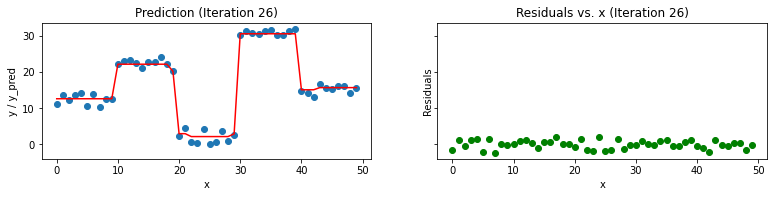

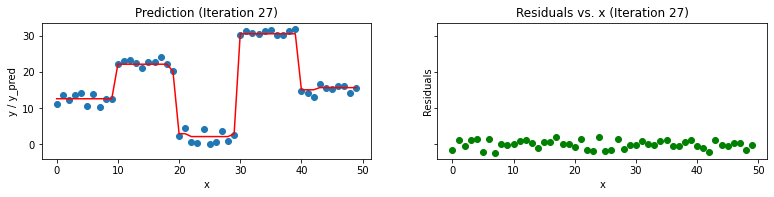

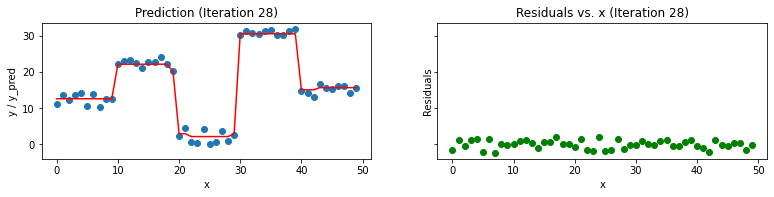

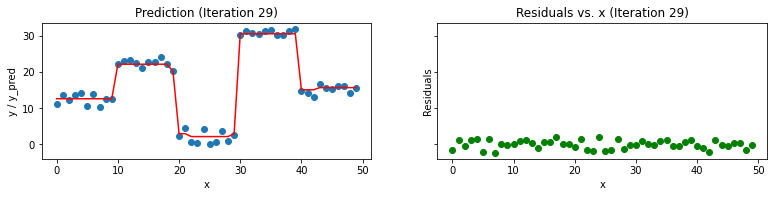

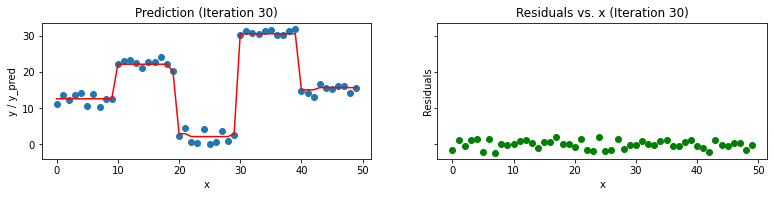

In [8]:
xi = x # define  input
yi = y # define  target
ei = 0 # error
n = len(yi)  # rows
predf = 0 # initial prediction

for i in range(30): # 30 trees 
    tree = DecisionTree(xi,yi) # create decision tree 
    tree.findbettersplit(0)  # split the branches such that std.deviation is minimum 
    
    r = np.where(xi == tree.split)[0][0]   #  index of the split
    
    left_index = np.where(xi <= tree.split)[0] # left index
    right_index = np.where(xi > tree.split)[0] # right index 
    
    predi = np.zeros(n)
    np.put(predi, left_index, np.repeat(np.mean(yi[left_index]), r))  # left mean y
    np.put(predi, right_index, np.repeat(np.mean(yi[right_index]), n-r))  # right mean y
    
    predi = predi[:,None]  
    predf = predf + predi  # add residual to the previous prediction value 
    
    ei = y - predf  # originl y     
    yi = ei # update yi
    
    
    # plotting after prediction
    xa = np.array(x.x)
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction {i+1}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'residuals vs. x {i+1}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('residuals')
    
    